In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

modelFileName = "model.pkl"
dataFileName  = "input/NizhnyNovgorod.csv"

Model = None
with open( modelFileName, 'rb') as fid:
        Model = cPickle.load(fid)
allDataFrame = loadData( dataFileName, COLUMN_TYPE='ALL' )

allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Tokenization took: 42.06 ms
Type conversion took: 81.72 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 20.48 ms
Type conversion took: 66.50 ms
Parser memory cleanup took: 0.01 ms
Shape of the data with all features: (109400, 11)
Shape of the data with numerical features: (109400, 11)
List of features contained our dataset: ['type', 'price', 'longitude', 'latitude', 'total_square', 'living_square', 'kitchen_square', 'number_of_rooms', 'floor_number', 'number_of_floors', 'building_type']
Shape of the data with numerical features: (63533, 11)
RobustScaler  [59007.04176027] [27882.38455357]
Shape of the data with numerical features: (46559, 11)


,type,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors,building_type
0,Вторичка,2850000.0,44.075417,56.283864,43.0,14.0,11.0,1,9,17,
1,Вторичка,8200000.0,43.942485,56.301539,98.5,52.0,14.0,3,3,17,
2,Вторичка,2600000.0,43.923782,56.310448,64.0,42.0,6.0,4,2,5,
3,Вторичка,2750000.0,44.064952,56.291499,50.0,30.0,9.0,2,3,5,
4,Вторичка,2650000.0,43.957127,56.329128,45.0,31.0,6.0,2,2,5,Кирпичный
5,Вторичка,2400000.0,44.023674,56.316345,76.0,44.0,12.0,2,6,9,
6,Вторичка,3700000.0,43.996545,56.317807,45.0,37.0,6.5,2,2,8,Кирпичный
7,Вторичка,3550000.0,44.079100,56.303541,41.8,18.6,11.3,1,9,9,Кирпичный
9,Вторичка,1900000.0,44.001350,56.310740,57.0,27.0,12.0,1,6,12,
12,Вторичка,4760000.0,43.943589,56.295000,105.0,64.0,10.0,4,8,9,Кирпичный


In [2]:
allDataFrame.describe()

,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors
count,4.655900e+04,46559.000000,46559.000000,46559.000000,46559.000000,46559.000000,46559.000000,46559.000000,46559.000000
mean,3.085855e+06,43.934308,56.296133,51.872585,30.447150,8.872970,1.981851,5.195215,9.480208
std,1.515704e+06,0.079438,0.040989,21.208696,14.166703,4.192216,0.890809,4.087210,5.556267
min,5.500000e+05,43.704484,56.115176,13.000000,8.000000,4.000000,1.000000,1.000000,1.000000
25%,2.130105e+06,43.865077,56.265181,37.400000,18.500000,6.000000,1.000000,2.000000,5.000000
50%,2.725770e+06,43.931175,56.298842,46.000000,29.000000,8.000000,2.000000,4.000000,9.000000
75%,3.600000e+06,44.005753,56.326887,62.000000,38.000000,10.000000,3.000000,7.000000,10.000000
max,3.000000e+07,44.265365,56.490082,480.000000,300.000000,95.000000,9.000000,27.000000,50.000000


In [3]:
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame[NUMERICAL_COLUMNS]

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       Y_values = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); X_values = X_dataFrame.values;
Y_values    = Y_values.ravel()

Y_predict = Model.predict( X_values )

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )

Errors on the test set
mean square:      292040730608.26794
mean absolute:    162760.3335568172
median_absolute:  56477.34375


threshold =   2.5, good =      25797, bad =      20762, err = 0.44592882149530705
threshold =   5.0, good =      35919, bad =      10640, err = 0.22852724500096652
threshold =  10.0, good =      42172, bad =       4387, err = 0.09422453231383836


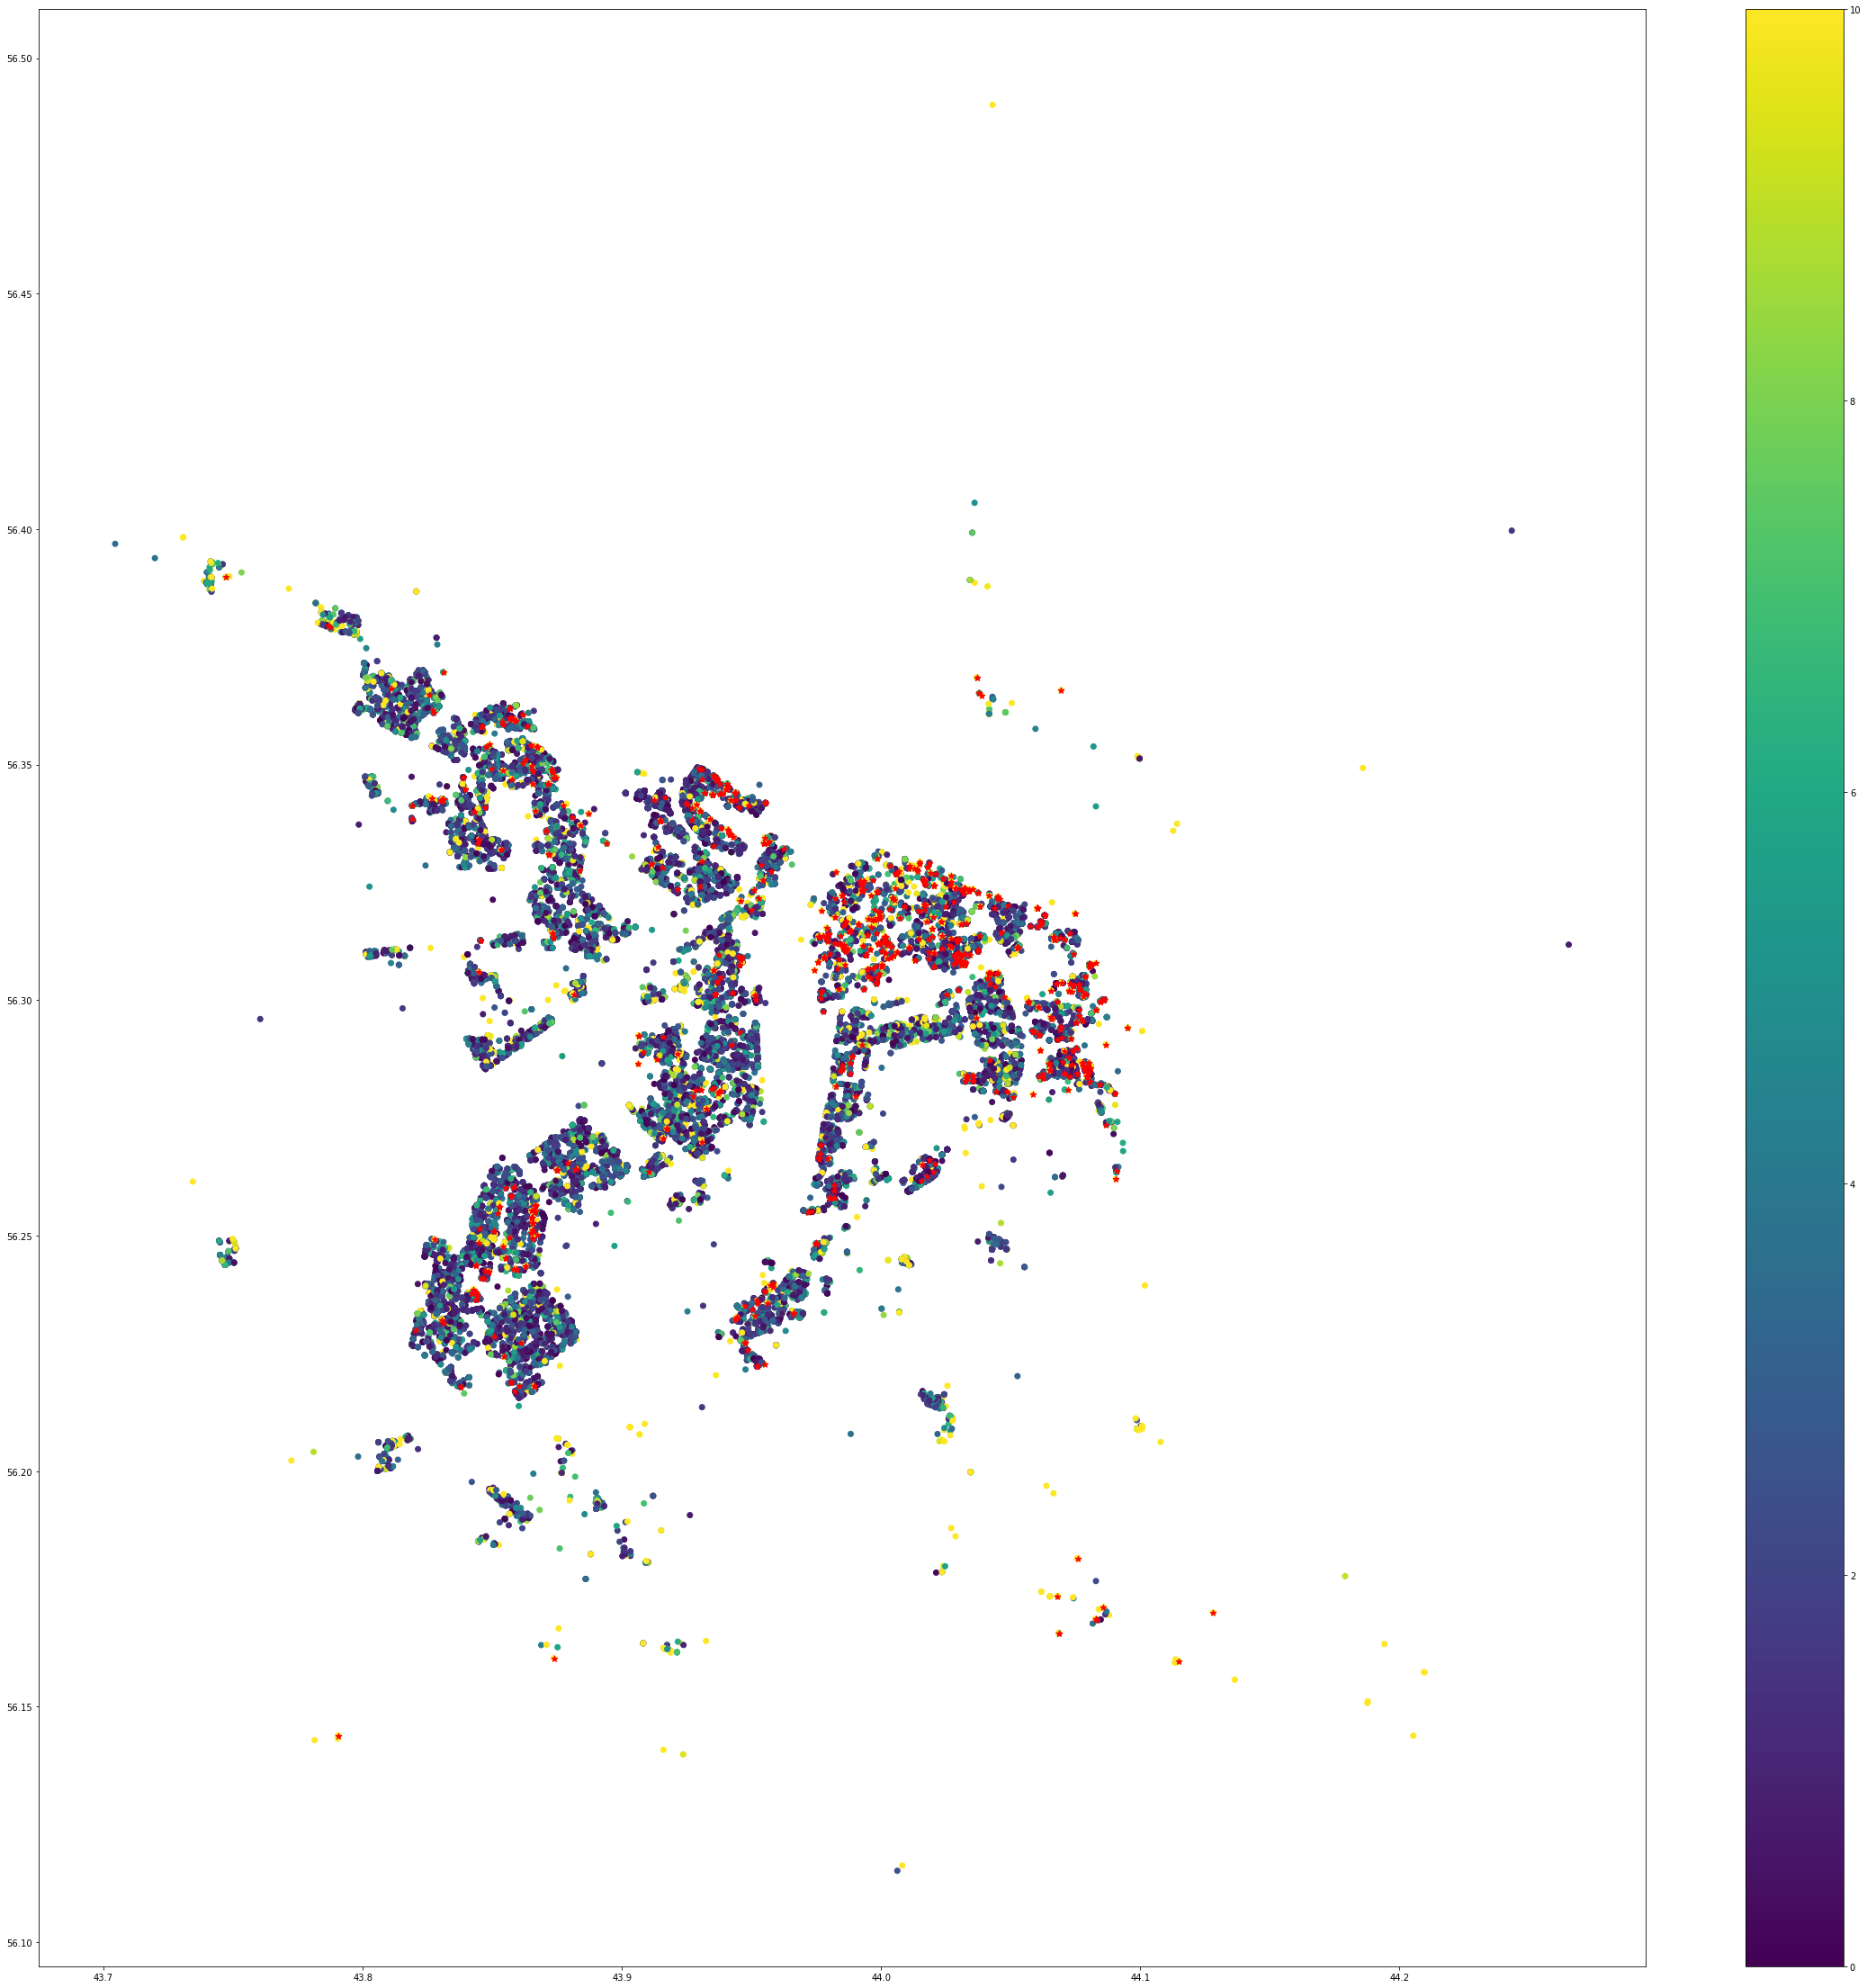

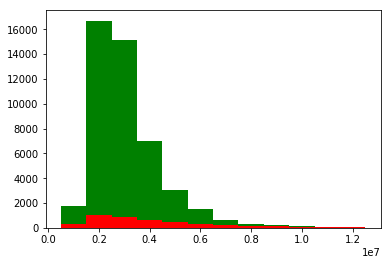

Плохие  примеры [ 328. 1022.  852.  615.  446.  324.  213.  126.  139.  104.   62.   54.]
Хорошие примеры [ 1722. 16689. 15141.  7005.  3022.  1522.   656.   288.   190.   106.
    62.    54.]
Отношение       [ 5.25       16.3297456  17.77112676 11.3902439   6.77578475  4.69753086
  3.07981221  2.28571429  1.36690647  1.01923077  1.          1.        ]


In [4]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 10 );

plt.figure(figsize=(40,40))
plt.scatter (x, y, c=c  )
plt.colorbar()

mask = ( Y_values < 1e6 ) & ( Y_relErr > 10 )
x_low = X_values[mask,0]; y_low = X_values[mask,1]; c_low = 'red'
plt.scatter (x_low, y_low, c=c_low, marker="*", s=48  )
mask = ( Y_values > 5e6 ) & ( Y_relErr > 10 )
x_high = X_values[mask,0]; y_high = X_values[mask,1]; c_high = 'red'
plt.scatter (x_high, y_high, c=c_high, marker="*", s=48  )

plt.show    ()

threshold = 10
mask = Y_relErr >  threshold
badTestDataValues = testDataFrame[ mask ].price.values
mask = Y_relErr <= threshold
goodTestDataValues = testDataFrame[ mask ].price.values

bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]
bins = [i * 1e6 for i in bins]

n = plt.hist([badTestDataValues, goodTestDataValues], bins=bins, histtype='barstacked', color=['red','green'], label = ['bad', 'good'])
plt.show()

print('Плохие  примеры', n[0][0] )
print('Хорошие примеры', n[0][1] )
print('Отношение      ', n[0][1]/n[0][0])

In [5]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
type                Вторичка
price                3.5e+06
longitude             44.006
latitude             56.3269
total_square             104
living_square             66
kitchen_square             9
number_of_rooms            5
floor_number               2
number_of_floors           2
building_type               
Name: 90109, dtype: object
CLOSEST record
type                Вторичка
price                1.7e+06
longitude             44.006
latitude             56.3269
total_square            31.2
living_square           14.5
kitchen_square           8.2
number_of_rooms            1
floor_number               1
number_of_floors           3
building_type               
Name: 92, dtype: object
CLOSEST record
type                 Вторичка
price                 3.3e+06
longitude              44.006
latitude              56.3269
total_square             43.7
living_square            27.6
kitchen_square            7.5
number_of_rooms             2
floor_number                9

CLOSEST record
type                Вторичка
price               2.45e+06
longitude             44.006
latitude             56.3269
total_square              48
living_square             28
kitchen_square           6.3
number_of_rooms            2
floor_number               3
number_of_floors           9
building_type               
Name: 3186, dtype: object
CLOSEST record
type                 Вторичка
price                4.12e+06
longitude              44.006
latitude              56.3269
total_square               61
living_square            39.4
kitchen_square            7.5
number_of_rooms             3
floor_number                8
number_of_floors            9
building_type       Кирпичный
Name: 3190, dtype: object
CLOSEST record
type                Вторичка
price                2.2e+06
longitude             44.006
latitude             56.3269
total_square              34
living_square             18
kitchen_square           9.2
number_of_rooms            1
floor_number          

CLOSEST record
type                Новостройка
price                   4.8e+06
longitude                44.006
latitude                56.3269
total_square              76.99
living_square             46.96
kitchen_square             11.3
number_of_rooms               3
floor_number                  7
number_of_floors              8
building_type                  
Name: 9619, dtype: object
CLOSEST record
type                Вторичка
price                2.4e+06
longitude             44.006
latitude             56.3269
total_square              33
living_square             18
kitchen_square             6
number_of_rooms            1
floor_number               2
number_of_floors           9
building_type               
Name: 9710, dtype: object
CLOSEST record
type                Вторичка
price                2.7e+06
longitude             44.006
latitude             56.3269
total_square              49
living_square             28
kitchen_square           9.5
number_of_rooms            2


CLOSEST record
type                 Вторичка
price                2.72e+06
longitude              44.006
latitude              56.3269
total_square             42.8
living_square            25.5
kitchen_square            7.4
number_of_rooms             2
floor_number                7
number_of_floors            9
building_type       Кирпичный
Name: 11656, dtype: object
CLOSEST record
type                 Вторичка
price                 3.8e+06
longitude              44.006
latitude              56.3269
total_square             64.5
living_square              33
kitchen_square              9
number_of_rooms             2
floor_number                3
number_of_floors            6
building_type       Кирпичный
Name: 11657, dtype: object
CLOSEST record
type                 Вторичка
price                3.25e+06
longitude              44.006
latitude              56.3269
total_square               80
living_square              46
kitchen_square             10
number_of_rooms             3
f

CLOSEST record
type                Вторичка
price                1.7e+06
longitude             44.006
latitude             56.3269
total_square            30.6
living_square           14.5
kitchen_square           8.5
number_of_rooms            1
floor_number               1
number_of_floors           3
building_type               
Name: 13517, dtype: object
CLOSEST record
type                 Вторичка
price                 1.3e+06
longitude              44.006
latitude              56.3269
total_square             31.4
living_square            20.9
kitchen_square            5.4
number_of_rooms             1
floor_number                2
number_of_floors            2
building_type       Кирпичный
Name: 13789, dtype: object
CLOSEST record
type                 Вторичка
price                1.98e+06
longitude              44.006
latitude              56.3269
total_square               40
living_square              23
kitchen_square            7.5
number_of_rooms             2
floor_number

Name: 15782, dtype: object
CLOSEST record
type                Вторичка
price               2.45e+06
longitude             44.006
latitude             56.3269
total_square              44
living_square             27
kitchen_square             6
number_of_rooms            2
floor_number               4
number_of_floors           5
building_type               
Name: 15837, dtype: object
CLOSEST record
type                Вторичка
price               1.65e+06
longitude             44.006
latitude             56.3269
total_square              42
living_square           19.2
kitchen_square           5.6
number_of_rooms            1
floor_number               1
number_of_floors           5
building_type               
Name: 15880, dtype: object
CLOSEST record
type                Вторичка
price               2.34e+06
longitude             44.006
latitude             56.3269
total_square            30.4
living_square           17.5
kitchen_square             6
number_of_rooms            1
floo

CLOSEST record
type                Вторичка
price                  4e+06
longitude             44.006
latitude             56.3269
total_square              62
living_square             31
kitchen_square            11
number_of_rooms            2
floor_number               6
number_of_floors          17
building_type               
Name: 19057, dtype: object
CLOSEST record
type                Вторичка
price                2.7e+06
longitude             44.006
latitude             56.3269
total_square              60
living_square             42
kitchen_square           5.5
number_of_rooms            4
floor_number               5
number_of_floors           5
building_type               
Name: 19451, dtype: object
CLOSEST record
type                Вторичка
price               2.14e+06
longitude             44.006
latitude             56.3269
total_square              44
living_square             28
kitchen_square             6
number_of_rooms            2
floor_number               1
nu

CLOSEST record
type                Вторичка
price                1.9e+06
longitude             44.006
latitude             56.3269
total_square              50
living_square             37
kitchen_square             8
number_of_rooms            2
floor_number               2
number_of_floors           2
building_type               
Name: 26693, dtype: object
CLOSEST record
type                Вторичка
price                2.6e+06
longitude             44.006
latitude             56.3269
total_square            58.4
living_square             46
kitchen_square             6
number_of_rooms            3
floor_number               1
number_of_floors           5
building_type               
Name: 26809, dtype: object
CLOSEST record
type                Вторичка
price                5.7e+06
longitude             44.006
latitude             56.3269
total_square             108
living_square             75
kitchen_square            10
number_of_rooms            5
floor_number               4
nu

CLOSEST record
type                 Вторичка
price                 2.2e+06
longitude              44.006
latitude              56.3269
total_square               42
living_square              32
kitchen_square             10
number_of_rooms             1
floor_number                2
number_of_floors            2
building_type       Кирпичный
Name: 31021, dtype: object
CLOSEST record
type                 Вторичка
price               2.415e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square            13.5
kitchen_square             16
number_of_rooms             1
floor_number               14
number_of_floors           19
building_type       Панельный
Name: 31149, dtype: object
CLOSEST record
type                 Вторичка
price                 3.2e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              28
kitchen_square             10
number_of_rooms             1
f

CLOSEST record
type                 Вторичка
price                 2.9e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              27
kitchen_square              7
number_of_rooms             2
floor_number                2
number_of_floors            9
building_type       Панельный
Name: 35016, dtype: object
CLOSEST record
type                 Вторичка
price                1.75e+06
longitude              44.006
latitude              56.3269
total_square             30.5
living_square            18.7
kitchen_square              5
number_of_rooms             1
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 35076, dtype: object
CLOSEST record
type                 Вторичка
price                 1.6e+06
longitude              44.006
latitude              56.3269
total_square             28.5
living_square            18.1
kitchen_square            5.3
number_of_rooms             1
f

CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square             34.5
living_square            17.4
kitchen_square            7.8
number_of_rooms             1
floor_number                5
number_of_floors            9
building_type       Панельный
Name: 39124, dtype: object
CLOSEST record
type                  Вторичка
price                 2.35e+06
longitude               44.006
latitude               56.3269
total_square              39.9
living_square             17.1
kitchen_square               9
number_of_rooms              1
floor_number                 4
number_of_floors            10
building_type       Монолитный
Name: 39212, dtype: object
CLOSEST record
type                  Вторичка
price                   700000
longitude               44.006
latitude               56.3269
total_square                15
living_square               10
kitchen_square               5
number_of_roo

CLOSEST record
type                 Вторичка
price                 2.8e+06
longitude              44.006
latitude              56.3269
total_square             43.9
living_square            30.6
kitchen_square            5.7
number_of_rooms             2
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 43088, dtype: object
CLOSEST record
type                 Вторичка
price                 1.8e+06
longitude              44.006
latitude              56.3269
total_square             30.1
living_square              19
kitchen_square            5.5
number_of_rooms             1
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 43089, dtype: object
CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square               39
living_square              19
kitchen_square            9.3
number_of_rooms             1
f

CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square              43
living_square             22
kitchen_square            10
number_of_rooms            2
floor_number              17
number_of_floors          17
building_type               
Name: 46906, dtype: object
CLOSEST record
type                Вторичка
price               6.15e+06
longitude             44.006
latitude             56.3269
total_square            81.3
living_square           68.6
kitchen_square           7.8
number_of_rooms            4
floor_number               1
number_of_floors           6
building_type               
Name: 47106, dtype: object
CLOSEST record
type                Вторичка
price                2.6e+06
longitude             44.006
latitude             56.3269
total_square              67
living_square             49
kitchen_square             5
number_of_rooms            3
floor_number               2
nu

Name: 57235, dtype: object
CLOSEST record
type                 Вторичка
price                2.45e+06
longitude              44.006
latitude              56.3269
total_square             58.5
living_square            42.9
kitchen_square            5.3
number_of_rooms             4
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 57240, dtype: object
CLOSEST record
type                  Вторичка
price                  8.6e+06
longitude               44.006
latitude               56.3269
total_square              99.3
living_square             71.3
kitchen_square              14
number_of_rooms              3
floor_number                 9
number_of_floors            19
building_type       Монолитный
Name: 57377, dtype: object
CLOSEST record
type                 Вторичка
price                3.15e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square            17.5
kitchen_square         

CLOSEST record
type                 Вторичка
price                3.35e+06
longitude              44.006
latitude              56.3269
total_square             70.2
living_square              48
kitchen_square            6.9
number_of_rooms             3
floor_number                5
number_of_floors            9
building_type       Кирпичный
Name: 61446, dtype: object
CLOSEST record
type                 Вторичка
price                 1.3e+07
longitude              44.006
latitude              56.3269
total_square            167.8
living_square            96.8
kitchen_square             25
number_of_rooms             4
floor_number                2
number_of_floors            4
building_type       Кирпичный
Name: 61452, dtype: object
CLOSEST record
type                   Вторичка
price               5.70503e+06
longitude                44.006
latitude                56.3269
total_square               91.1
living_square              46.8
kitchen_square             15.7
number_of_rooms  

CLOSEST record
type                 Вторичка
price                 2.9e+06
longitude              44.006
latitude              56.3269
total_square               59
living_square            41.2
kitchen_square            5.9
number_of_rooms             3
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 66654, dtype: object
CLOSEST record
type                 Вторичка
price                 2.2e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              17
kitchen_square             11
number_of_rooms             1
floor_number                4
number_of_floors            9
building_type       Панельный
Name: 67382, dtype: object
CLOSEST record
type                 Вторичка
price                2.25e+06
longitude              44.006
latitude              56.3269
total_square             45.3
living_square            30.6
kitchen_square              6
number_of_rooms             2
f

CLOSEST record
type                 Вторичка
price               5.275e+06
longitude              44.006
latitude              56.3269
total_square               71
living_square              34
kitchen_square             19
number_of_rooms             2
floor_number                2
number_of_floors           10
building_type                
Name: 72271, dtype: object
CLOSEST record
type                Вторичка
price                3.5e+06
longitude             44.006
latitude             56.3269
total_square              69
living_square             35
kitchen_square            12
number_of_rooms            2
floor_number              15
number_of_floors          17
building_type               
Name: 72287, dtype: object
CLOSEST record
type                 Вторичка
price                 3.5e+06
longitude              44.006
latitude              56.3269
total_square             74.4
living_square            49.2
kitchen_square              6
number_of_rooms             3
floor_number

CLOSEST record
type                Вторичка
price               2.38e+06
longitude             44.006
latitude             56.3269
total_square              31
living_square             22
kitchen_square             8
number_of_rooms            1
floor_number               6
number_of_floors          10
building_type               
Name: 76775, dtype: object
CLOSEST record
type                 Вторичка
price                 9.9e+06
longitude              44.006
latitude              56.3269
total_square              130
living_square              85
kitchen_square             20
number_of_rooms             4
floor_number                2
number_of_floors           10
building_type       Кирпичный
Name: 76884, dtype: object
CLOSEST record
type                 Вторичка
price                1.55e+06
longitude              44.006
latitude              56.3269
total_square               33
living_square              18
kitchen_square            5.8
number_of_rooms             1
floor_number

CLOSEST record
type                 Вторичка
price                1.55e+06
longitude              44.006
latitude              56.3269
total_square               31
living_square              18
kitchen_square            5.5
number_of_rooms             1
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 81596, dtype: object
CLOSEST record
type                 Вторичка
price                3.65e+06
longitude              44.006
latitude              56.3269
total_square               52
living_square            32.8
kitchen_square            6.1
number_of_rooms             2
floor_number                5
number_of_floors            9
building_type       Кирпичный
Name: 81674, dtype: object
CLOSEST record
type                 Вторичка
price                1.39e+06
longitude              44.006
latitude              56.3269
total_square               29
living_square              18
kitchen_square              5
number_of_rooms             1
f

CLOSEST record
type                  Вторичка
price               5.6515e+06
longitude               44.006
latitude               56.3269
total_square              92.2
living_square             46.8
kitchen_square            15.4
number_of_rooms              3
floor_number                 3
number_of_floors            17
building_type       Монолитный
Name: 85388, dtype: object
CLOSEST record
type                Вторичка
price                2.8e+06
longitude             44.006
latitude             56.3269
total_square            54.5
living_square             33
kitchen_square           5.9
number_of_rooms            3
floor_number               1
number_of_floors           5
building_type               
Name: 85455, dtype: object
CLOSEST record
type                Вторичка
price               2.73e+06
longitude             44.006
latitude             56.3269
total_square              52
living_square             28
kitchen_square             9
number_of_rooms            2
floor_num

CLOSEST record
type                 Вторичка
price                 1.8e+06
longitude              44.006
latitude              56.3269
total_square             41.1
living_square            30.1
kitchen_square              5
number_of_rooms             2
floor_number                3
number_of_floors            4
building_type       Панельный
Name: 88005, dtype: object
CLOSEST record
type                 Вторичка
price                 2.3e+06
longitude              44.006
latitude              56.3269
total_square               32
living_square              17
kitchen_square            6.5
number_of_rooms             1
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 88006, dtype: object
CLOSEST record
type                Вторичка
price                6.9e+06
longitude             44.006
latitude             56.3269
total_square           116.6
living_square           64.2
kitchen_square          14.4
number_of_rooms            4
floor_num

CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square             31.5
living_square            17.9
kitchen_square            5.6
number_of_rooms             1
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 90501, dtype: object
CLOSEST record
type                  Вторичка
price                 2.85e+06
longitude               44.006
latitude               56.3269
total_square                48
living_square               25
kitchen_square               8
number_of_rooms              2
floor_number                 6
number_of_floors            17
building_type       Монолитный
Name: 90561, dtype: object
CLOSEST record
type                Вторичка
price               2.45e+06
longitude             44.006
latitude             56.3269
total_square              33
living_square             18
kitchen_square             7
number_of_rooms            

CLOSEST record
type                 Вторичка
price                 2.3e+06
longitude              44.006
latitude              56.3269
total_square             45.7
living_square            27.3
kitchen_square            5.5
number_of_rooms             2
floor_number                4
number_of_floors            5
building_type       Панельный
Name: 93392, dtype: object
CLOSEST record
type                 Вторичка
price                 2.7e+06
longitude              44.006
latitude              56.3269
total_square             45.6
living_square            28.5
kitchen_square            6.1
number_of_rooms             2
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 93413, dtype: object
CLOSEST record
type                 Вторичка
price                1.35e+06
longitude              44.006
latitude              56.3269
total_square               30
living_square            17.5
kitchen_square            5.8
number_of_rooms             1
f

CLOSEST record
type                Вторичка
price                4.5e+06
longitude             44.006
latitude             56.3269
total_square              78
living_square           43.6
kitchen_square            12
number_of_rooms            3
floor_number               8
number_of_floors          17
building_type               
Name: 97246, dtype: object
CLOSEST record
type                Новостройка
price                  3.55e+06
longitude                44.006
latitude                56.3269
total_square               66.1
living_square              36.6
kitchen_square             10.8
number_of_rooms               3
floor_number                  7
number_of_floors             10
building_type                  
Name: 97442, dtype: object
CLOSEST record
type                 Вторичка
price               2.299e+06
longitude              44.006
latitude              56.3269
total_square               35
living_square              17
kitchen_square            9.1
number_of_rooms     

CLOSEST record
type                 Вторичка
price                 2.4e+06
longitude              44.006
latitude              56.3269
total_square             48.2
living_square              32
kitchen_square              6
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Панельный
Name: 102248, dtype: object
CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square               33
living_square            17.1
kitchen_square            8.2
number_of_rooms             1
floor_number                7
number_of_floors            9
building_type       Панельный
Name: 103132, dtype: object
CLOSEST record
type                 Вторичка
price                4.22e+06
longitude              44.006
latitude              56.3269
total_square             52.7
living_square            30.3
kitchen_square              8
number_of_rooms             2

CLOSEST record
type                 Вторичка
price               2.499e+06
longitude              44.006
latitude              56.3269
total_square               49
living_square              32
kitchen_square              6
number_of_rooms             2
floor_number                4
number_of_floors            5
building_type       Панельный
Name: 106858, dtype: object
CLOSEST record
type                Вторичка
price                3.1e+06
longitude             44.006
latitude             56.3269
total_square              65
living_square             38
kitchen_square             9
number_of_rooms            3
floor_number               2
number_of_floors           9
building_type               
Name: 106999, dtype: object
CLOSEST record
type                 Вторичка
price                9.65e+06
longitude              44.006
latitude              56.3269
total_square              130
living_square              85
kitchen_square             20
number_of_rooms             4
floor_numb


BASE record
type                 Вторичка
price                 2.6e+06
longitude             44.0078
latitude              56.3277
total_square               76
living_square              52
kitchen_square             10
number_of_rooms             5
floor_number                2
number_of_floors            4
building_type       Кирпичный
Name: 15863, dtype: object
CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude             44.0078
latitude              56.3277
total_square               76
living_square              52
kitchen_square             10
number_of_rooms             5
floor_number                2
number_of_floors            4
building_type       Кирпичный
Name: 15863, dtype: object
CLOSEST record
type                Вторичка
price                2.6e+06
longitude            44.0079
latitude             56.3279
total_square              76
living_square             52
kitchen_square            10
number_of_rooms            5
floor_numbe

CLOSEST record
type                Вторичка
price               2.45e+06
longitude             44.006
latitude             56.3269
total_square              48
living_square             28
kitchen_square           6.3
number_of_rooms            2
floor_number               3
number_of_floors           9
building_type               
Name: 3186, dtype: object
CLOSEST record
type                 Вторичка
price                4.12e+06
longitude              44.006
latitude              56.3269
total_square               61
living_square            39.4
kitchen_square            7.5
number_of_rooms             3
floor_number                8
number_of_floors            9
building_type       Кирпичный
Name: 3190, dtype: object
CLOSEST record
type                Вторичка
price                2.2e+06
longitude             44.006
latitude             56.3269
total_square              34
living_square             18
kitchen_square           9.2
number_of_rooms            1
floor_number          

CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude              44.006
latitude              56.3269
total_square               42
living_square              29
kitchen_square            5.8
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 8929, dtype: object
CLOSEST record
type                 Вторичка
price                   4e+06
longitude              44.006
latitude              56.3269
total_square               68
living_square              44
kitchen_square            7.5
number_of_rooms             3
floor_number                5
number_of_floors            9
building_type       Панельный
Name: 8931, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square               63
living_square            43.9
kitchen_square            7.1
number_of_rooms             3
flo

CLOSEST record
type                 Вторичка
price                2.45e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              26
kitchen_square            7.7
number_of_rooms             2
floor_number                1
number_of_floors            2
building_type       Кирпичный
Name: 11106, dtype: object
CLOSEST record
type                 Вторичка
price                 8.9e+06
longitude              44.006
latitude              56.3269
total_square              168
living_square              98
kitchen_square             21
number_of_rooms             5
floor_number                6
number_of_floors            7
building_type       Кирпичный
Name: 11107, dtype: object
CLOSEST record
type                Вторичка
price                4.1e+06
longitude             44.006
latitude             56.3269
total_square            75.5
living_square           37.7
kitchen_square            13
number_of_rooms            2
floor_num

CLOSEST record
type                 Вторичка
price                2.06e+06
longitude              44.006
latitude              56.3269
total_square               47
living_square              30
kitchen_square              7
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 13230, dtype: object
CLOSEST record
type                Вторичка
price               2.15e+06
longitude             44.006
latitude             56.3269
total_square              46
living_square             30
kitchen_square             6
number_of_rooms            2
floor_number               4
number_of_floors           5
building_type               
Name: 13324, dtype: object
CLOSEST record
type                Вторичка
price                1.7e+06
longitude             44.006
latitude             56.3269
total_square            30.6
living_square           14.5
kitchen_square           8.5
number_of_rooms            1
floor_number        

CLOSEST record
type                 Вторичка
price                 2.5e+06
longitude              44.006
latitude              56.3269
total_square             45.8
living_square              27
kitchen_square            8.5
number_of_rooms             2
floor_number                2
number_of_floors            4
building_type       Кирпичный
Name: 15174, dtype: object
CLOSEST record
type                 Вторичка
price                2.69e+06
longitude              44.006
latitude              56.3269
total_square             45.4
living_square            34.8
kitchen_square            5.8
number_of_rooms             2
floor_number                2
number_of_floors            2
building_type       Кирпичный
Name: 15288, dtype: object
CLOSEST record
type                 Вторичка
price                3.25e+06
longitude              44.006
latitude              56.3269
total_square             62.3
living_square            47.9
kitchen_square            6.1
number_of_rooms             3
f

CLOSEST record
type                Вторичка
price               2.59e+06
longitude             44.006
latitude             56.3269
total_square              43
living_square             29
kitchen_square             6
number_of_rooms            2
floor_number               2
number_of_floors           5
building_type               
Name: 17850, dtype: object
CLOSEST record
type                Вторичка
price               2.18e+06
longitude             44.006
latitude             56.3269
total_square            53.4
living_square             34
kitchen_square           6.6
number_of_rooms            3
floor_number               2
number_of_floors           2
building_type               
Name: 17851, dtype: object
CLOSEST record
type                Вторичка
price               1.65e+06
longitude             44.006
latitude             56.3269
total_square              33
living_square             16
kitchen_square             5
number_of_rooms            1
floor_number               3
nu

CLOSEST record
type                Вторичка
price                2.1e+06
longitude             44.006
latitude             56.3269
total_square              45
living_square             27
kitchen_square             7
number_of_rooms            2
floor_number               8
number_of_floors           9
building_type               
Name: 25520, dtype: object
CLOSEST record
type                 Вторичка
price                2.57e+06
longitude              44.006
latitude              56.3269
total_square               44
living_square              28
kitchen_square              7
number_of_rooms             2
floor_number                3
number_of_floors            9
building_type       Панельный
Name: 25728, dtype: object
CLOSEST record
type                 Вторичка
price                2.05e+06
longitude              44.006
latitude              56.3269
total_square             44.7
living_square            29.4
kitchen_square            5.2
number_of_rooms             2
floor_number

Name: 29529, dtype: object
CLOSEST record
type                 Вторичка
price                 5.2e+06
longitude              44.006
latitude              56.3269
total_square              111
living_square              80
kitchen_square             14
number_of_rooms             4
floor_number                7
number_of_floors           11
building_type       Кирпичный
Name: 29531, dtype: object
CLOSEST record
type                 Вторичка
price                1.88e+06
longitude              44.006
latitude              56.3269
total_square             29.9
living_square            17.8
kitchen_square            5.5
number_of_rooms             1
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 29532, dtype: object
CLOSEST record
type                 Вторичка
price                 2.3e+06
longitude              44.006
latitude              56.3269
total_square             35.9
living_square            19.5
kitchen_square            8.1
numb

CLOSEST record
type                 Вторичка
price                1.77e+06
longitude              44.006
latitude              56.3269
total_square             42.2
living_square            28.6
kitchen_square              6
number_of_rooms             2
floor_number                1
number_of_floors            4
building_type       Кирпичный
Name: 34205, dtype: object
CLOSEST record
type                 Вторичка
price                4.85e+06
longitude              44.006
latitude              56.3269
total_square               70
living_square            42.4
kitchen_square              9
number_of_rooms             3
floor_number                9
number_of_floors            9
building_type       Панельный
Name: 34214, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square              47
living_square             27
kitchen_square             6
number_of_rooms            2
floor_num

CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square             34.5
living_square            17.4
kitchen_square            7.8
number_of_rooms             1
floor_number                5
number_of_floors            9
building_type       Панельный
Name: 39124, dtype: object
CLOSEST record
type                  Вторичка
price                 2.35e+06
longitude               44.006
latitude               56.3269
total_square              39.9
living_square             17.1
kitchen_square               9
number_of_rooms              1
floor_number                 4
number_of_floors            10
building_type       Монолитный
Name: 39212, dtype: object
CLOSEST record
type                  Вторичка
price                   700000
longitude               44.006
latitude               56.3269
total_square                15
living_square               10
kitchen_square               5
number_of_roo

CLOSEST record
type                 Вторичка
price                 2.8e+06
longitude              44.006
latitude              56.3269
total_square             43.9
living_square            30.6
kitchen_square            5.7
number_of_rooms             2
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 43088, dtype: object
CLOSEST record
type                 Вторичка
price                 1.8e+06
longitude              44.006
latitude              56.3269
total_square             30.1
living_square              19
kitchen_square            5.5
number_of_rooms             1
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 43089, dtype: object
CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square               39
living_square              19
kitchen_square            9.3
number_of_rooms             1
f

CLOSEST record
type                Вторичка
price                2.6e+06
longitude             44.006
latitude             56.3269
total_square              67
living_square             49
kitchen_square             5
number_of_rooms            3
floor_number               2
number_of_floors           4
building_type               
Name: 49127, dtype: object
CLOSEST record
type                 Вторичка
price                 3.3e+06
longitude              44.006
latitude              56.3269
total_square             45.6
living_square              10
kitchen_square           20.8
number_of_rooms             1
floor_number                9
number_of_floors            9
building_type       Кирпичный
Name: 49892, dtype: object
CLOSEST record
type                Вторичка
price                  2e+06
longitude             44.006
latitude             56.3269
total_square              49
living_square             31
kitchen_square             6
number_of_rooms            2
floor_number        

CLOSEST record
type                 Вторичка
price                1.05e+07
longitude              44.006
latitude              56.3269
total_square              130
living_square              85
kitchen_square             20
number_of_rooms             4
floor_number                2
number_of_floors           10
building_type       Кирпичный
Name: 55573, dtype: object
CLOSEST record
type                 Вторичка
price                 2.8e+06
longitude              44.006
latitude              56.3269
total_square             65.9
living_square            46.2
kitchen_square            7.6
number_of_rooms             3
floor_number                4
number_of_floors            4
building_type       Кирпичный
Name: 55583, dtype: object
CLOSEST record
type                Вторичка
price                2.8e+06
longitude             44.006
latitude             56.3269
total_square            48.2
living_square             28
kitchen_square           5.5
number_of_rooms            2
floor_num

Name: 59622, dtype: object
CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude              44.006
latitude              56.3269
total_square               47
living_square              32
kitchen_square              7
number_of_rooms             2
floor_number                5
number_of_floors            9
building_type       Панельный
Name: 59728, dtype: object
CLOSEST record
type                 Вторичка
price                 2.8e+06
longitude              44.006
latitude              56.3269
total_square               42
living_square              28
kitchen_square              6
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 60226, dtype: object
CLOSEST record
type                 Вторичка
price                 3.2e+06
longitude              44.006
latitude              56.3269
total_square               60
living_square              40
kitchen_square              9
numb

type                  Вторичка
price                  2.5e+06
longitude               44.006
latitude               56.3269
total_square                56
living_square               32
kitchen_square             8.7
number_of_rooms              2
floor_number                10
number_of_floors            19
building_type       Монолитный
Name: 64945, dtype: object
CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square               21
living_square              12
kitchen_square              5
number_of_rooms             1
floor_number                7
number_of_floors            9
building_type       Кирпичный
Name: 64946, dtype: object
CLOSEST record
type                Вторичка
price                3.9e+06
longitude             44.006
latitude             56.3269
total_square            53.4
living_square           27.6
kitchen_square           8.7
number_of_rooms            2
floor_number 

CLOSEST record
type                Вторичка
price                3.7e+06
longitude             44.006
latitude             56.3269
total_square              61
living_square             45
kitchen_square           7.5
number_of_rooms            3
floor_number               1
number_of_floors           9
building_type               
Name: 70871, dtype: object
CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square               22
living_square              12
kitchen_square            5.5
number_of_rooms             1
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 70921, dtype: object
CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square             44.3
living_square              28
kitchen_square              6
number_of_rooms             2
floor_number

Name: 76097, dtype: object
CLOSEST record
type                 Вторичка
price                2.25e+06
longitude              44.006
latitude              56.3269
total_square             44.9
living_square            33.5
kitchen_square            5.5
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Панельный
Name: 76099, dtype: object
CLOSEST record
type                Вторичка
price               1.42e+06
longitude             44.006
latitude             56.3269
total_square              30
living_square             14
kitchen_square             8
number_of_rooms            1
floor_number               2
number_of_floors           3
building_type        Блочный
Name: 76108, dtype: object
CLOSEST record
type                Вторичка
price                3.3e+06
longitude             44.006
latitude             56.3269
total_square              61
living_square             45
kitchen_square           7.5
number_of_rooms       

CLOSEST record
type                 Вторичка
price                   1e+07
longitude              44.006
latitude              56.3269
total_square              116
living_square              79
kitchen_square             15
number_of_rooms             3
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 82081, dtype: object
CLOSEST record
type                 Вторичка
price                3.75e+06
longitude              44.006
latitude              56.3269
total_square             73.4
living_square              46
kitchen_square            8.7
number_of_rooms             3
floor_number                4
number_of_floors            9
building_type       Кирпичный
Name: 82197, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square             47.6
living_square            33.7
kitchen_square            5.9
number_of_rooms             2
f

CLOSEST record
type                 Вторичка
price                 2.2e+06
longitude              44.006
latitude              56.3269
total_square             51.2
living_square            34.8
kitchen_square              6
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 86514, dtype: object
CLOSEST record
type                 Вторичка
price                4.75e+06
longitude              44.006
latitude              56.3269
total_square             84.6
living_square            55.5
kitchen_square              9
number_of_rooms             4
floor_number                2
number_of_floors            4
building_type       Кирпичный
Name: 86843, dtype: object
CLOSEST record
type                 Вторичка
price                3.09e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              12
kitchen_square             18
number_of_rooms             2
f

Name: 89844, dtype: object
CLOSEST record
type                 Вторичка
price                2.09e+06
longitude              44.006
latitude              56.3269
total_square             27.9
living_square              16
kitchen_square            6.2
number_of_rooms             1
floor_number                1
number_of_floors            6
building_type       Кирпичный
Name: 89845, dtype: object
CLOSEST record
type                 Вторичка
price               2.499e+06
longitude              44.006
latitude              56.3269
total_square             44.6
living_square              29
kitchen_square            5.9
number_of_rooms             2
floor_number                1
number_of_floors            5
building_type       Панельный
Name: 89846, dtype: object
CLOSEST record
type                 Вторичка
price                 3.4e+06
longitude              44.006
latitude              56.3269
total_square             51.4
living_square            29.6
kitchen_square            8.5
numb

Name: 92954, dtype: object
CLOSEST record
type                 Вторичка
price                2.65e+06
longitude              44.006
latitude              56.3269
total_square             43.4
living_square            29.2
kitchen_square            6.2
number_of_rooms             2
floor_number                4
number_of_floors            5
building_type       Панельный
Name: 92955, dtype: object
CLOSEST record
type                 Вторичка
price                1.45e+06
longitude              44.006
latitude              56.3269
total_square               28
living_square              13
kitchen_square              7
number_of_rooms             1
floor_number                7
number_of_floors            9
building_type       Кирпичный
Name: 92956, dtype: object
CLOSEST record
type                 Вторичка
price                2.25e+06
longitude              44.006
latitude              56.3269
total_square               35
living_square              18
kitchen_square            9.5
numb

Name: 97246, dtype: object
CLOSEST record
type                Новостройка
price                  3.55e+06
longitude                44.006
latitude                56.3269
total_square               66.1
living_square              36.6
kitchen_square             10.8
number_of_rooms               3
floor_number                  7
number_of_floors             10
building_type                  
Name: 97442, dtype: object
CLOSEST record
type                 Вторичка
price               2.299e+06
longitude              44.006
latitude              56.3269
total_square               35
living_square              17
kitchen_square            9.1
number_of_rooms             1
floor_number                8
number_of_floors            9
building_type       Панельный
Name: 97754, dtype: object
CLOSEST record
type                Вторичка
price                2.3e+06
longitude             44.006
latitude             56.3269
total_square              67
living_square             46
kitchen_square    

CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square               33
living_square            17.1
kitchen_square            8.2
number_of_rooms             1
floor_number                7
number_of_floors            9
building_type       Панельный
Name: 103132, dtype: object
CLOSEST record
type                 Вторичка
price                4.22e+06
longitude              44.006
latitude              56.3269
total_square             52.7
living_square            30.3
kitchen_square              8
number_of_rooms             2
floor_number                4
number_of_floors            9
building_type       Кирпичный
Name: 103138, dtype: object
CLOSEST record
type                 Вторичка
price                 7.8e+06
longitude              44.006
latitude              56.3269
total_square              100
living_square              50
kitchen_square             15
number_of_rooms             3

CLOSEST record
type                 Вторичка
price                2.55e+06
longitude              44.006
latitude              56.3269
total_square             57.9
living_square              39
kitchen_square              6
number_of_rooms             3
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 108721, dtype: object
CLOSEST record
type                 Вторичка
price                1.97e+06
longitude              44.006
latitude              56.3269
total_square               38
living_square              25
kitchen_square            5.5
number_of_rooms             2
floor_number                2
number_of_floors            3
building_type       Кирпичный
Name: 108890, dtype: object

BASE record
type                  Вторичка
price                 2.35e+06
longitude              43.9354
latitude               56.3014
total_square                70
living_square               42
kitchen_square              19
number_of_rooms         

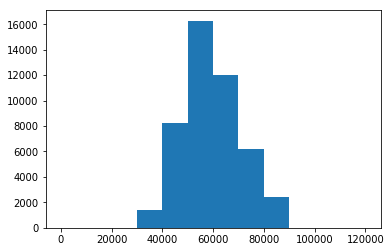

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

import matplotlib.pyplot as plt

bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]

pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

plt.hist(  pricePerSquareValues, bins=bins )
plt.show()


In [7]:
#Базовый пример
Плохие  примеры [ 449. 1184. 1159.  744.  566.  397.  198.  138.  159.  140.  108.   76.]
Хорошие примеры [ 1866. 16796. 15332.  7260.  3204.  1707.   812.   373.   264.   151.
   108.    76.]
Отношение       [ 4.155902   14.18581081 13.22864538  9.75806452  5.66077739  4.29974811
  4.1010101   2.70289855  1.66037736  1.07857143  1.          1.        ]

#Текущий пример
Плохие  примеры [273. 810. 733. 591. 436. 305. 226. 121. 130. 104.  62.  54.]
Хорошие примеры [ 1722. 16689. 15141.  7005.  3022.  1522.   656.   288.   190.   106.
    62.    54.]
Отношение       [ 6.30769231 20.6037037  20.65620737 11.85279188  6.93119266  4.99016393
  2.90265487  2.38016529  1.46153846  1.01923077  1.          1.        ]

Плохие  примеры [ 328. 1022.  852.  615.  446.  324.  213.  126.  139.  104.   62.   54.]
Хорошие примеры [ 1722. 16689. 15141.  7005.  3022.  1522.   656.   288.   190.   106.
    62.    54.]
Отношение       [ 5.25       16.3297456  17.77112676 11.3902439   6.77578475  4.69753086
  3.07981221  2.28571429  1.36690647  1.01923077  1.          1.        ]


SyntaxError: invalid syntax (<ipython-input-7-a1f90b7246d8>, line 2)